# Predicting Hotel Cancellations

## 🏨 Background

You are supporting a hotel with a project aimed to increase revenue from their room bookings. They believe that they can use data science to help them reduce the number of cancellations. This is where you come in! 

They have asked you to use any appropriate methodology to identify what contributes to whether a booking will be fulfilled or cancelled. They intend to use the results of your work to reduce the chance someone cancels their booking.

## The Data

They have provided you with their bookings data in a file called `hotel_bookings.csv`, which contains the following:

| Column     | Description              |
|------------|--------------------------|
| `Booking_ID` | Unique identifier of the booking. |
| `no_of_adults` | The number of adults. |
| `no_of_children` | The number of children. |
| `no_of_weekend_nights` | Number of weekend nights (Saturday or Sunday). |
| `no_of_week_nights` | Number of week nights (Monday to Friday). |
| `type_of_meal_plan` | Type of meal plan included in the booking. |
| `required_car_parking_space` | Whether a car parking space is required. |
| `room_type_reserved` | The type of room reserved. |
| `lead_time` | Number of days before the arrival date the booking was made. |
| `arrival_year` | Year of arrival. |
| `arrival_month` | Month of arrival. |
| `arrival_date` | Date of the month for arrival. |
| `market_segment_type` | How the booking was made. |
| `repeated_guest` | Whether the guest has previously stayed at the hotel. |
| `no_of_previous_cancellations` | Number of previous cancellations. |
| `no_of_previous_bookings_not_canceled` | Number of previous bookings that were canceled. |
| `avg_price_per_room` | Average price per day of the booking. |
| `no_of_special_requests` | Count of special requests made as part of the booking. |
| `booking_status` | Whether the booking was cancelled or not. |

Source (data has been modified): https://www.kaggle.com/datasets/ahsan81/hotel-reservations-classification-dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# set up global styles for plots
plt.style.use('fivethirtyeight')
sns.set_context("notebook", font_scale=1)

# load the data
hotels = pd.read_csv("../data/hotel_bookings.csv")
hotels

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Not_Canceled
1,INN00002,2.0,0.0,2.0,3.0,Not Selected,0.0,Room_Type 1,5.0,2018.0,11.0,6.0,Online,0.0,0.0,0.0,106.68,1.0,Not_Canceled
2,INN00003,1.0,0.0,2.0,1.0,Meal Plan 1,0.0,Room_Type 1,1.0,2018.0,2.0,28.0,Online,0.0,0.0,0.0,60.00,0.0,Canceled
3,INN00004,2.0,0.0,0.0,2.0,Meal Plan 1,0.0,Room_Type 1,211.0,2018.0,5.0,20.0,Online,0.0,0.0,0.0,100.00,0.0,Canceled
4,INN00005,2.0,0.0,1.0,1.0,Not Selected,0.0,Room_Type 1,48.0,2018.0,4.0,11.0,Online,0.0,0.0,0.0,94.50,0.0,Canceled
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36270,INN36271,3.0,0.0,2.0,NaN,Meal Plan 1,0.0,NaN,85.0,2018.0,8.0,3.0,Online,NaN,0.0,0.0,167.80,1.0,Not_Canceled
36271,INN36272,2.0,0.0,1.0,3.0,Meal Plan 1,0.0,Room_Type 1,228.0,2018.0,10.0,17.0,Online,0.0,0.0,0.0,90.95,2.0,Canceled
36272,INN36273,2.0,0.0,2.0,6.0,Meal Plan 1,0.0,Room_Type 1,148.0,2018.0,7.0,1.0,Online,0.0,0.0,0.0,98.39,2.0,Not_Canceled
36273,INN36274,2.0,0.0,0.0,3.0,Not Selected,0.0,Room_Type 1,63.0,2018.0,4.0,21.0,Online,0.0,0.0,0.0,94.50,0.0,Canceled


## Data Cleaning

Before we being to analyse the data let's first:

* Explore
* Clean 
* Verify

In [2]:
# rename 'Booking_ID' column to 'booking_id' for consistency
hotels.rename(columns={'Booking_ID': 'booking_id'}, inplace=True)
# confirm
display(hotels.columns)

Index(['booking_id', 'no_of_adults', 'no_of_children', 'no_of_weekend_nights',
       'no_of_week_nights', 'type_of_meal_plan', 'required_car_parking_space',
       'room_type_reserved', 'lead_time', 'arrival_year', 'arrival_month',
       'arrival_date', 'market_segment_type', 'repeated_guest',
       'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled',
       'avg_price_per_room', 'no_of_special_requests', 'booking_status'],
      dtype='object')

In [3]:
# let's see what the shape of the data is
hotels.shape

(36275, 19)

In [4]:
# check for missing values
hotels.isnull().sum()

booking_id                                 0
no_of_adults                             413
no_of_children                           324
no_of_weekend_nights                     367
no_of_week_nights                        807
type_of_meal_plan                        526
required_car_parking_space              2592
room_type_reserved                      1171
lead_time                                472
arrival_year                             378
arrival_month                            504
arrival_date                             981
market_segment_type                     1512
repeated_guest                           586
no_of_previous_cancellations             497
no_of_previous_bookings_not_canceled     550
avg_price_per_room                       460
no_of_special_requests                   789
booking_status                             0
dtype: int64

In [5]:
# first let's remove any rows where least 17 values are missing
hotels.dropna(thresh=17, inplace=True)
# confirm
hotels.shape

(35358, 19)

In [6]:
# check percentage of missing values
def get_percentage_of_missing_values(df):
    return round(df.isnull().sum()/len(df) * 100, 1)
    
display(get_percentage_of_missing_values(hotels))

booking_id                              0.0
no_of_adults                            0.6
no_of_children                          0.5
no_of_weekend_nights                    0.7
no_of_week_nights                       1.8
type_of_meal_plan                       1.1
required_car_parking_space              6.2
room_type_reserved                      2.7
lead_time                               0.9
arrival_year                            0.5
arrival_month                           0.6
arrival_date                            2.6
market_segment_type                     2.8
repeated_guest                          1.1
no_of_previous_cancellations            1.3
no_of_previous_bookings_not_canceled    0.8
avg_price_per_room                      1.2
no_of_special_requests                  1.7
booking_status                          0.0
dtype: float64

In [7]:
# let's take these missing values and replace them appropriately
# a few numerical columns have a very small percentage of missing values, 
# and a small range of possible values, so we can replace them with the 
# most frequent value in that column (the mode)
cols = [
    'no_of_adults', 
    'no_of_children',
    'no_of_weekend_nights',
    'no_of_week_nights'
]

for col in cols:
    hotels[col].fillna(hotels[col].mode()[0], inplace=True)

In [8]:
# next let's replace numerical columns with the mean
cols = [
    'lead_time',
    'avg_price_per_room',
    'no_of_previous_cancellations',
    'no_of_previous_bookings_not_canceled',
    'no_of_special_requests'    
]
for col in cols:
    hotels[col].fillna(hotels[col].mean(), inplace=True)

# next let's replace categorical columns with the most used value
cols = [
    'type_of_meal_plan',
    'room_type_reserved',
    'market_segment_type'
]
for col in cols:
    hotels[col].fillna(hotels[col].value_counts().index[0], inplace=True)

# replace null booleans with False
cols = [
    'required_car_parking_space',
    'repeated_guest'
]
for col in cols:
    hotels[col].fillna(False, inplace=True)

# replace null dates with ffill
cols = [
    'arrival_date',
    'arrival_year',
    'arrival_month'
]
for col in cols:
    hotels[col].fillna(method='ffill', inplace=True)

# confirm changes
display(get_percentage_of_missing_values(hotels))


booking_id                              0.0
no_of_adults                            0.0
no_of_children                          0.0
no_of_weekend_nights                    0.0
no_of_week_nights                       0.0
type_of_meal_plan                       0.0
required_car_parking_space              0.0
room_type_reserved                      0.0
lead_time                               0.0
arrival_year                            0.0
arrival_month                           0.0
arrival_date                            0.0
market_segment_type                     0.0
repeated_guest                          0.0
no_of_previous_cancellations            0.0
no_of_previous_bookings_not_canceled    0.0
avg_price_per_room                      0.0
no_of_special_requests                  0.0
booking_status                          0.0
dtype: float64

In [9]:
# next check data types of columns are as expected
display(hotels.dtypes)

booking_id                               object
no_of_adults                            float64
no_of_children                          float64
no_of_weekend_nights                    float64
no_of_week_nights                       float64
type_of_meal_plan                        object
required_car_parking_space               object
room_type_reserved                       object
lead_time                               float64
arrival_year                            float64
arrival_month                           float64
arrival_date                            float64
market_segment_type                      object
repeated_guest                           object
no_of_previous_cancellations            float64
no_of_previous_bookings_not_canceled    float64
avg_price_per_room                      float64
no_of_special_requests                  float64
booking_status                           object
dtype: object

In [10]:
# change multiple float columns to int, except avg_price_per_room
cols = [
    'no_of_special_requests',
    'no_of_children',
    'no_of_adults',
    'no_of_weekend_nights',
    'no_of_week_nights',
    'required_car_parking_space',
    'lead_time',
    'arrival_year',
    'arrival_month',
    'arrival_date',
    'repeated_guest',
    'no_of_previous_cancellations',
    'no_of_previous_bookings_not_canceled',
    'no_of_special_requests'
]
for col in cols:
    hotels[col] = hotels[col].astype(int)

# confirm changes
display(hotels.dtypes)
display(hotels.head())


booking_id                               object
no_of_adults                              int64
no_of_children                            int64
no_of_weekend_nights                      int64
no_of_week_nights                         int64
type_of_meal_plan                        object
required_car_parking_space                int64
room_type_reserved                       object
lead_time                                 int64
arrival_year                              int64
arrival_month                             int64
arrival_date                              int64
market_segment_type                      object
repeated_guest                            int64
no_of_previous_cancellations              int64
no_of_previous_bookings_not_canceled      int64
avg_price_per_room                      float64
no_of_special_requests                    int64
booking_status                           object
dtype: object

,booking_id,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled
3,INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled
4,INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled
5,INN00006,2,0,0,2,Meal Plan 2,0,Room_Type 1,346,2018,9,13,Online,0,0,0,115.00,1,Canceled


In [11]:
# check for any duplicate rows
hotels.duplicated().sum()

0

In [12]:
# let's loop around and check the categorical columns are consistent
cols = [
    'booking_status',
    'type_of_meal_plan',
    'room_type_reserved',
    'market_segment_type'
]
for col in cols:
    print(col)
    print(hotels[col].value_counts())

booking_status
Not_Canceled    23775
Canceled        11583
Name: booking_status, dtype: int64
type_of_meal_plan
Meal Plan 1     27214
Not Selected     4943
Meal Plan 2      3196
Meal Plan 3         5
Name: type_of_meal_plan, dtype: int64
room_type_reserved
Room_Type 1    27650
Room_Type 4     5732
Room_Type 6      914
Room_Type 2      652
Room_Type 5      252
Room_Type 7      152
Room_Type 3        6
Name: room_type_reserved, dtype: int64
market_segment_type
Online           23000
Offline           9964
Corporate         1900
Complementary      372
Aviation           122
Name: market_segment_type, dtype: int64


## Analysis

Now we have the data cleaned, let's do some analysis to understand more about fulfilment and cancellations.

We are going to take 2 main approaches:
* Time Series Analysis, to see if we can forecast the cancellations over time
* Regression analysis, to see if we can build a model to predict bookings from the features in the dataset

To make looking at the data time series easier, let's add an extra date column to the dataset and add it to the dataframe.

In [13]:
# let's add a date column composed of the arrival_year, arrival_month and arrival_date
hotels = hotels.rename(columns={
    'arrival_year': 'year',
    'arrival_month': 'month',
    'arrival_date': 'day'
})
# some of the day values are invalid for the month, so we'll coerce them to NaT
hotels['date'] = pd.to_datetime(hotels[['year', 'month', 'day']], errors='coerce')
# there's 52 invalid dates
display(hotels['date'].isnull().sum())
# fix invalid date with ffills
hotels['date'].fillna(method='ffill', inplace=True)
# confirm
display(get_percentage_of_missing_values(hotels))
display(hotels.head())


52

booking_id                              0.0
no_of_adults                            0.0
no_of_children                          0.0
no_of_weekend_nights                    0.0
no_of_week_nights                       0.0
type_of_meal_plan                       0.0
required_car_parking_space              0.0
room_type_reserved                      0.0
lead_time                               0.0
year                                    0.0
month                                   0.0
day                                     0.0
market_segment_type                     0.0
repeated_guest                          0.0
no_of_previous_cancellations            0.0
no_of_previous_bookings_not_canceled    0.0
avg_price_per_room                      0.0
no_of_special_requests                  0.0
booking_status                          0.0
date                                    0.0
dtype: float64

,booking_id,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,year,month,day,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status,date
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled,2018-11-06
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled,2018-02-28
3,INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled,2018-05-20
4,INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled,2018-04-11
5,INN00006,2,0,0,2,Meal Plan 2,0,Room_Type 1,346,2018,9,13,Online,0,0,0,115.00,1,Canceled,2018-09-13


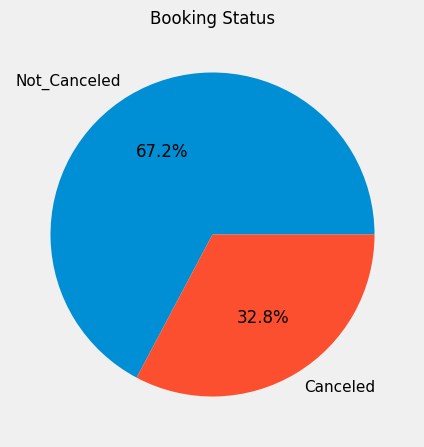

In [14]:
# plot booking status in a pie chart
plt.figure(figsize=(5, 5))
plt.pie(hotels['booking_status'].value_counts(), labels=hotels['booking_status'].value_counts().index, autopct='%1.1f%%')
plt.title('Booking Status')
plt.show()

Observartions from this graph - we have a good enough distribution of cancelled and not cancelled bookings to use as the foundation for a model.

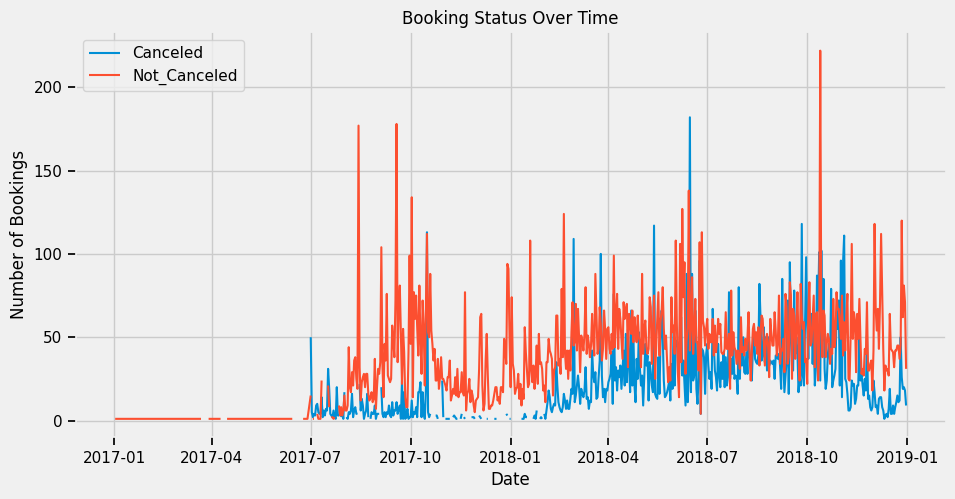

In [15]:
# plot cancelled or not cancelled booking status over time in a line chart
def plot_bookings_over_time(df):
    bookings_over_time = df.groupby('date')['booking_status'].value_counts().unstack()
    plt.figure(figsize=(10, 5))
    plt.plot(bookings_over_time.index, bookings_over_time['Canceled'])
    plt.plot(bookings_over_time.index, bookings_over_time['Not_Canceled'])
    plt.legend(['Canceled', 'Not_Canceled'])
    plt.title('Booking Status Over Time')
    plt.xlabel('Date')
    plt.ylabel('Number of Bookings')
    plt.show()

plot_bookings_over_time(hotels)

Observations from this graph:

* Visually it looks as though numbers of booking cancelled might have a relation to numbers not cancelled. We will explore this further.
* Data before 2017-07 is minimal, so we will remove those data points before progressing.

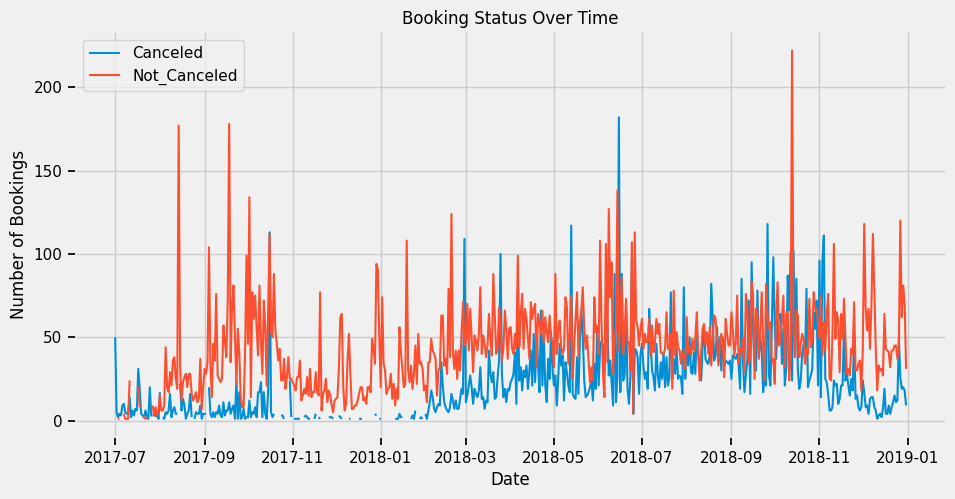

In [16]:
# remove bookings before 2017-07-01 from hotels dataframe
hotels = hotels[hotels['date'] >= '2017-07-01']
# verify
plot_bookings_over_time(hotels)

Ok - let's do some time series analysis and look at correlations and seasonality

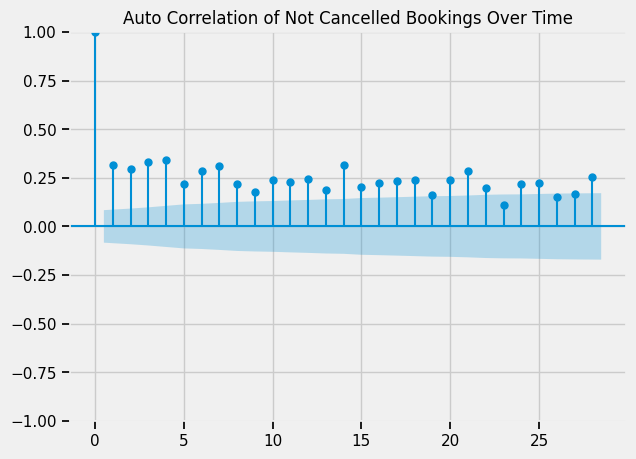

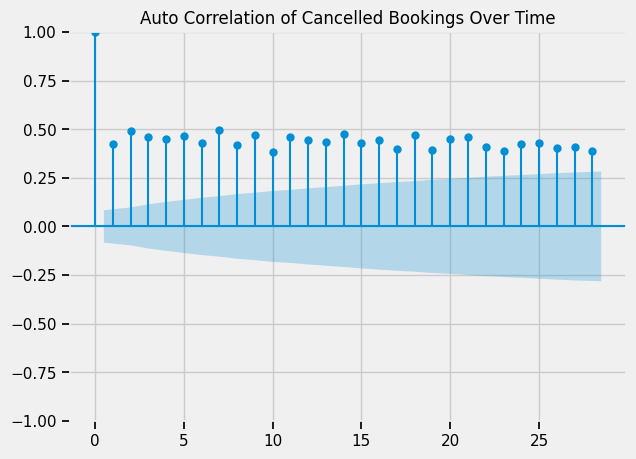

In [17]:
# look at auto correlation of bookings over time
from statsmodels.graphics.tsaplots import plot_acf
# create bookings over time from hotels dataframe replacing NaN with 0
bookings_over_time = hotels.groupby('date')['booking_status'].value_counts().unstack().fillna(0)
plot_acf(bookings_over_time['Not_Canceled'])
plt.title('Auto Correlation of Not Cancelled Bookings Over Time')
plt.show()

plot_acf(bookings_over_time['Canceled'])
plt.title('Auto Correlation of Cancelled Bookings Over Time')
plt.show()

These graphs show:
* There is a weak auto-corellation - the values extend beyond the blue shaded region indicating there is some pattern over time, but the range of 0.2 to 0.5 suggests it is not a strong one.
* For our data this result indicates it would be worthwhile continuing to attempt to forecast the data - and that forecasting cancellations would likely be more successful than forecasting non-cancellations.

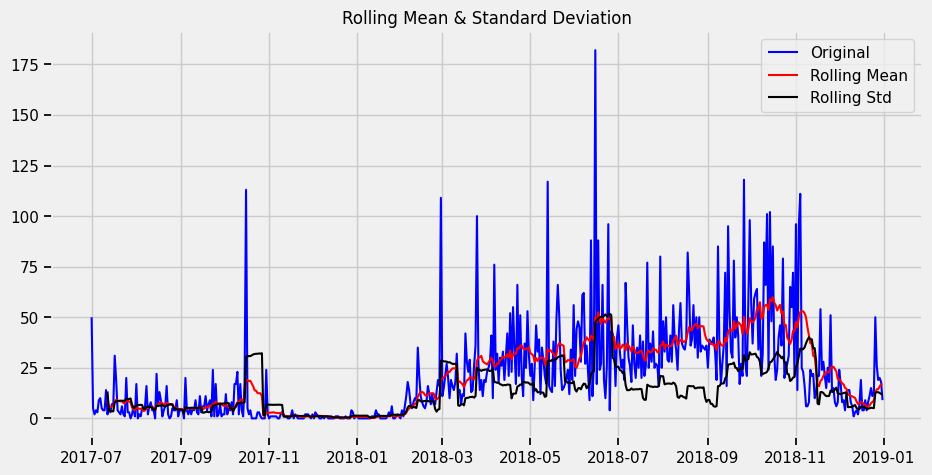

Results of Dickey-Fuller Test:
Test Statistic                  -1.811455
p-value                          0.374790
#Lags Used                      13.000000
Number of Observations Used    535.000000
Critical Value (1%)             -3.442632
Critical Value (5%)             -2.866957
Critical Value (10%)            -2.569655
dtype: float64


In [18]:
# perform a Dickey-Fuller test to check for stationarity
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    plt.figure(figsize=(10, 5))
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

test_stationarity(bookings_over_time['Canceled'])

Comparing the test statistic (-1.811455) with the critical value (-2.866957), we can see that the test statistic is greater than the critical value. This means that we cannot reject the null hypothesis of non-stationarity at the 5% significance level.

The test results suggest that there may still be some trend or other pattern in the cancelled bookings data that varies over time, which would make it non-stationary. This is reinforced by plotting out the mean and standard deviation.

Let's see if we can modify the data using the pandas diff method to get more stationarity.

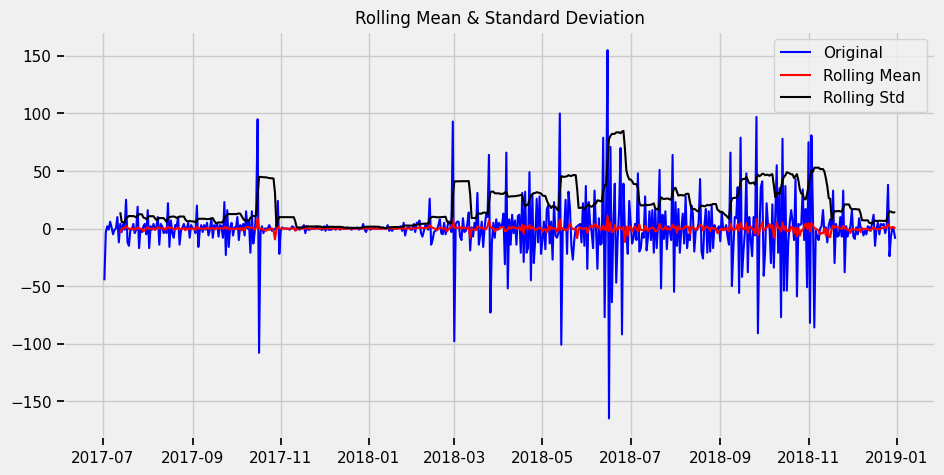

Results of Dickey-Fuller Test:
Test Statistic                -8.569628e+00
p-value                        8.264942e-14
#Lags Used                     1.900000e+01
Number of Observations Used    5.280000e+02
Critical Value (1%)           -3.442796e+00
Critical Value (5%)           -2.867030e+00
Critical Value (10%)          -2.569694e+00
dtype: float64


In [19]:
# use the diff method to remove the trend
bookings_over_time_stationary = bookings_over_time['Canceled'].diff().dropna()

test_stationarity(bookings_over_time_stationary)

Based on the results of the Dickey-Fuller test, the time series data can be considered stationary because the p-value is less than 0.05, and the Test Statistic is smaller than the critical values at the 1%, 5%, and 10% levels of significance. Additionally, the number of lags used is greater than 0, which suggests that the time series has some autocorrelation, but this is not necessarily an indicator of non-stationarity. Therefore, based on the Dickey-Fuller test results, we can conclude that the time series data is stationary.

Our data is now suitable for time series forecasting.

We will use an ARIMA model to forecast the upcoming cancellations.

TODO: 
* see run acf/pacf tests to identify order parameter attributes.
* Build ARIMA model
* get predictions and forecast
* then move onto regression model


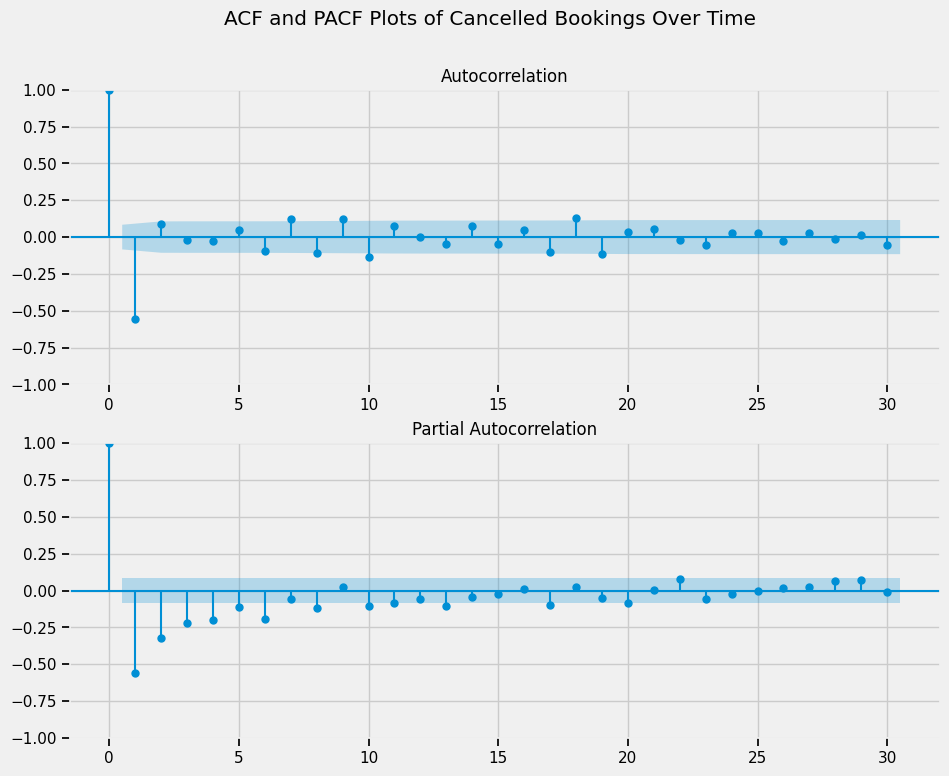

In [22]:
# run acf (auto-correlation) and pacf (partial auto-correlation) plots
# to determine p and q values for ARIMA model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,8))
fig.suptitle('ACF and PACF Plots of Cancelled Bookings Over Time')
plot_acf(bookings_over_time_stationary, lags=30, ax=ax1)
plot_pacf(bookings_over_time_stationary, lags=30, ax=ax2)
plt.show()


# TODO

1. Graph out basic cancellation data - how many etc? - DONE!!!
1. Remove data before 2017-07 - not enough data points - DONE!!!
1. Auto-correlation of canceled and not canceled - is there a pattern in the data in relation to itself - DONE!!!
1. is data stationary? DONE!!!
1. try and make it stationary - DONE
1. Predict cancellations in future - depends on type of time series - Arima or Forecast?
1. Build regression model for predicting based on features



# TODO

1. Feature engineering
1. Split data
1. Tune hyperparameters
1. Train model
1. Make predictions 
1. Assess performance

## The Challenge

* Use your skills to produce recommendations for the hotel on what factors affect whether customers cancel their booking.

### Note:

To ensure the best user experience, we currently discourage using Folium and Bokeh in Workspace notebooks.

## Judging Criteria

| CATEGORY | WEIGHTING | DETAILS                                                            |
|---------|----------|---------------------------------------------------------------------|
| **Recommendations** | 35%       | <ul><li>Clarity of recommendations - how clear and well presented the recommendation is.</li><li>Quality of recommendations - are appropriate analytical techniques used & are the conclusions valid?</li><li>Number of relevant insights found for the target audience.</li></ul>       |
| **Storytelling**  | 35%       | <ul><li>How well the data and insights are connected to the recommendation.</li><li>How the narrative and whole report connects together.</li><li>Balancing making the report in-depth enough but also concise.</li></ul>|
| **Visualizations** | 20% | <ul><li>Appropriateness of visualization used.</li><li>Clarity of insight from visualization.</li></ul>|
| **Votes** | 10% | <ul><li>Up voting - most upvoted entries get the most points.</li></ul> |

## Checklist before publishing


* Rename your workspace to make it descriptive of your work. N.B. you should leave the notebook name as notebook.ipynb.
* Remove redundant cells like the judging criteria, so the workbook is focused on your work.
* Check that all the cells run without error.

## Time is ticking. Good luck! 